In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}


In [3]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)



train_df = create_df("../../datasets/Oily-Dry-Skin-Types/train")
val_df = create_df("../../datasets/Oily-Dry-Skin-Types/valid")
test_df = create_df("../../datasets/Oily-Dry-Skin-Types/test")
train_df = pd.concat([train_df, val_df, test_df])

In [4]:
class Classification_Dataset(Dataset):
    def __init__(self, data, transform):
        super(Classification_Dataset, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [5]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

train

,images,labels
1295,../../datasets/Oily-Dry-Skin-Types/train\norma...,1
2312,../../datasets/Oily-Dry-Skin-Types/train\oily\...,2
764,../../datasets/Oily-Dry-Skin-Types/train\norma...,1
195,../../datasets/Oily-Dry-Skin-Types/valid\oily\...,2
50,../../datasets/Oily-Dry-Skin-Types/valid\dry\d...,0
...,...,...
74,../../datasets/Oily-Dry-Skin-Types/test\normal...,1
1095,../../datasets/Oily-Dry-Skin-Types/train\norma...,1
1130,../../datasets/Oily-Dry-Skin-Types/train\norma...,1
1294,../../datasets/Oily-Dry-Skin-Types/train\norma...,1


In [6]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [7]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [8]:
train_ds = Classification_Dataset(train, train_transform)
val_ds = Classification_Dataset(val, transform)

In [9]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [10]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

## Training

In [13]:
# best_model = deepcopy(model)
# best_acc = 0

# train_loss = []
# train_acc = []
# val_loss = []
# val_acc = []

# for i in range(1, EPOCHS+1):
#     model.train()
    
#     diff = 0
#     total = 0
#     acc = 0
    
#     for data, target in train_dl:
#         optimizer.zero_grad()
#         if torch.cuda.is_available():
#             data, target = data.cuda(), target.cuda()
            
#         out = model(data)
#         loss = criterion(out, target)
#         diff += loss.item()
#         acc += (out.argmax(1) == target).sum().item()
#         total += out.size(0)
#         loss.backward()
#         optimizer.step()
        
#     train_loss += [diff/total]
#     train_acc += [acc/total]
    
#     model.eval()
    
#     diff = 0
#     total = 0
#     acc = 0
    
#     with torch.no_grad():
#         for data, target in val_dl:
#             if torch.cuda.is_available():
#                 data, target = data.cuda(), target.cuda()
                
#             out = model(data)
#             loss = criterion(out, target)
#             diff += loss.item()
#             acc += (out.argmax(1) == target).sum().item()
#             total += out.size(0)
            
#     val_loss += [diff/total]
#     val_acc += [acc/total]
    
#     if val_acc[-1] > best_acc:
#         best_acc = val_acc[-1]
#         best_model = deepcopy(model)
        
#     scheduler.step()
    
#     print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
#                                                                     train_acc[-1], val_loss[-1],
#                                                                     val_acc[-1]))

In [14]:
best_model = torch.load("../../saved_models/skintype/best_20.pt")

In [15]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [16]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

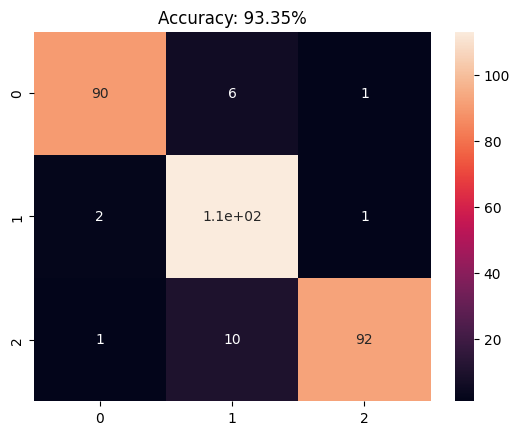

In [17]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [18]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        97
           1       0.88      0.97      0.92       116
           2       0.98      0.89      0.93       103

    accuracy                           0.93       316
   macro avg       0.94      0.93      0.93       316
weighted avg       0.94      0.93      0.93       316

